# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [33]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB, GaussianNB

import pickle

import random

import matplotlib.pyplot as plt

random_seed = 42

# Data Exploration

Podíváme se nejprve na data a trochu je prozkoumáme:

In [2]:
df_data = pd.read_csv('train.csv')

In [4]:
def split_data(data):
    print(f'Data shape: {data.shape}')
    labels = data['label']
    images = data.drop('label', axis=1)
    print(f'Images data shape: {images.shape}')
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.4, random_state=random_seed)
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_data(df_data)

Data shape: (2400, 785)
Images data shape: (2400, 784)
Train shape: (1440, 784)
Validation shape: (960, 784)


Pripravime si data i pro cross validaci:

In [5]:
X_cross_val = pd.concat((X_train, X_val))
y_cross_val = pd.concat((y_train, y_val))

Mame obrazkova data s velkou dimenzi - 784 pixelu a tedy i priznaku. Vybereme si nahodne 5 sloupcu a podivame se na to jak data vypadaji tabulkove.

In [18]:
n = 5
np.random.seed(random_seed)
data_train = pd.concat((y_train, X_train), axis=1)
random_indices = np.random.choice(range(1, data_train.shape[1]), size=n, replace=False)
selected_columns = data_train.head().iloc[:, selected_indices]
display(selected_columns)

,label,pixel598,pixel590,pixel209,pixel292,pixel175
1862,1,223,0,175,200,0
2261,0,0,0,173,136,0
607,0,53,0,143,138,0
415,1,230,0,224,228,232
273,0,0,0,226,226,0


Podivame se na obrazky a taky si vykreslime bar plot pro kazdy obrazek, kde muzeme uvidet kolik mame pixelu pro kazdou hodnotu.
Jak to bude videt na obrazcich, jako 0 klasifikujeme panty, jako 1 klasifikujeme šaty.

In [21]:
def draw_images(images, y, shape, scale=1, rd_seed=None):
    max_images = 2 * shape[0] * shape[1]
    images_sample = images.sample(n=max_images, random_state=rd_seed)
    labels_sample = y[images_sample.index]

    labels = labels_sample.to_numpy()
    images = images_sample.to_numpy()

    fig = plt.figure(figsize=(scale * 2 * shape[1], scale * 2 * shape[0]), constrained_layout=True)
    i = 0
    while i < max_images and i < images.shape[0]:
        ax_hist = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 1)
        ax_hist.hist(images[i], bins=256)
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel("Count (log scale)")
        ax_hist.set_xlabel("Pixel value")

        ax_image = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 2, xticks=[], yticks=[])
        image = images[i].reshape((28, 28))
        ax_image.imshow(image, cmap="Oranges", interpolation="nearest")
        ax_image.set_title(f"Trousers\n(Y = {labels[i]})" if labels[i] == 0 else f"Dress\n(Y = {labels[i]})")

        i += 2

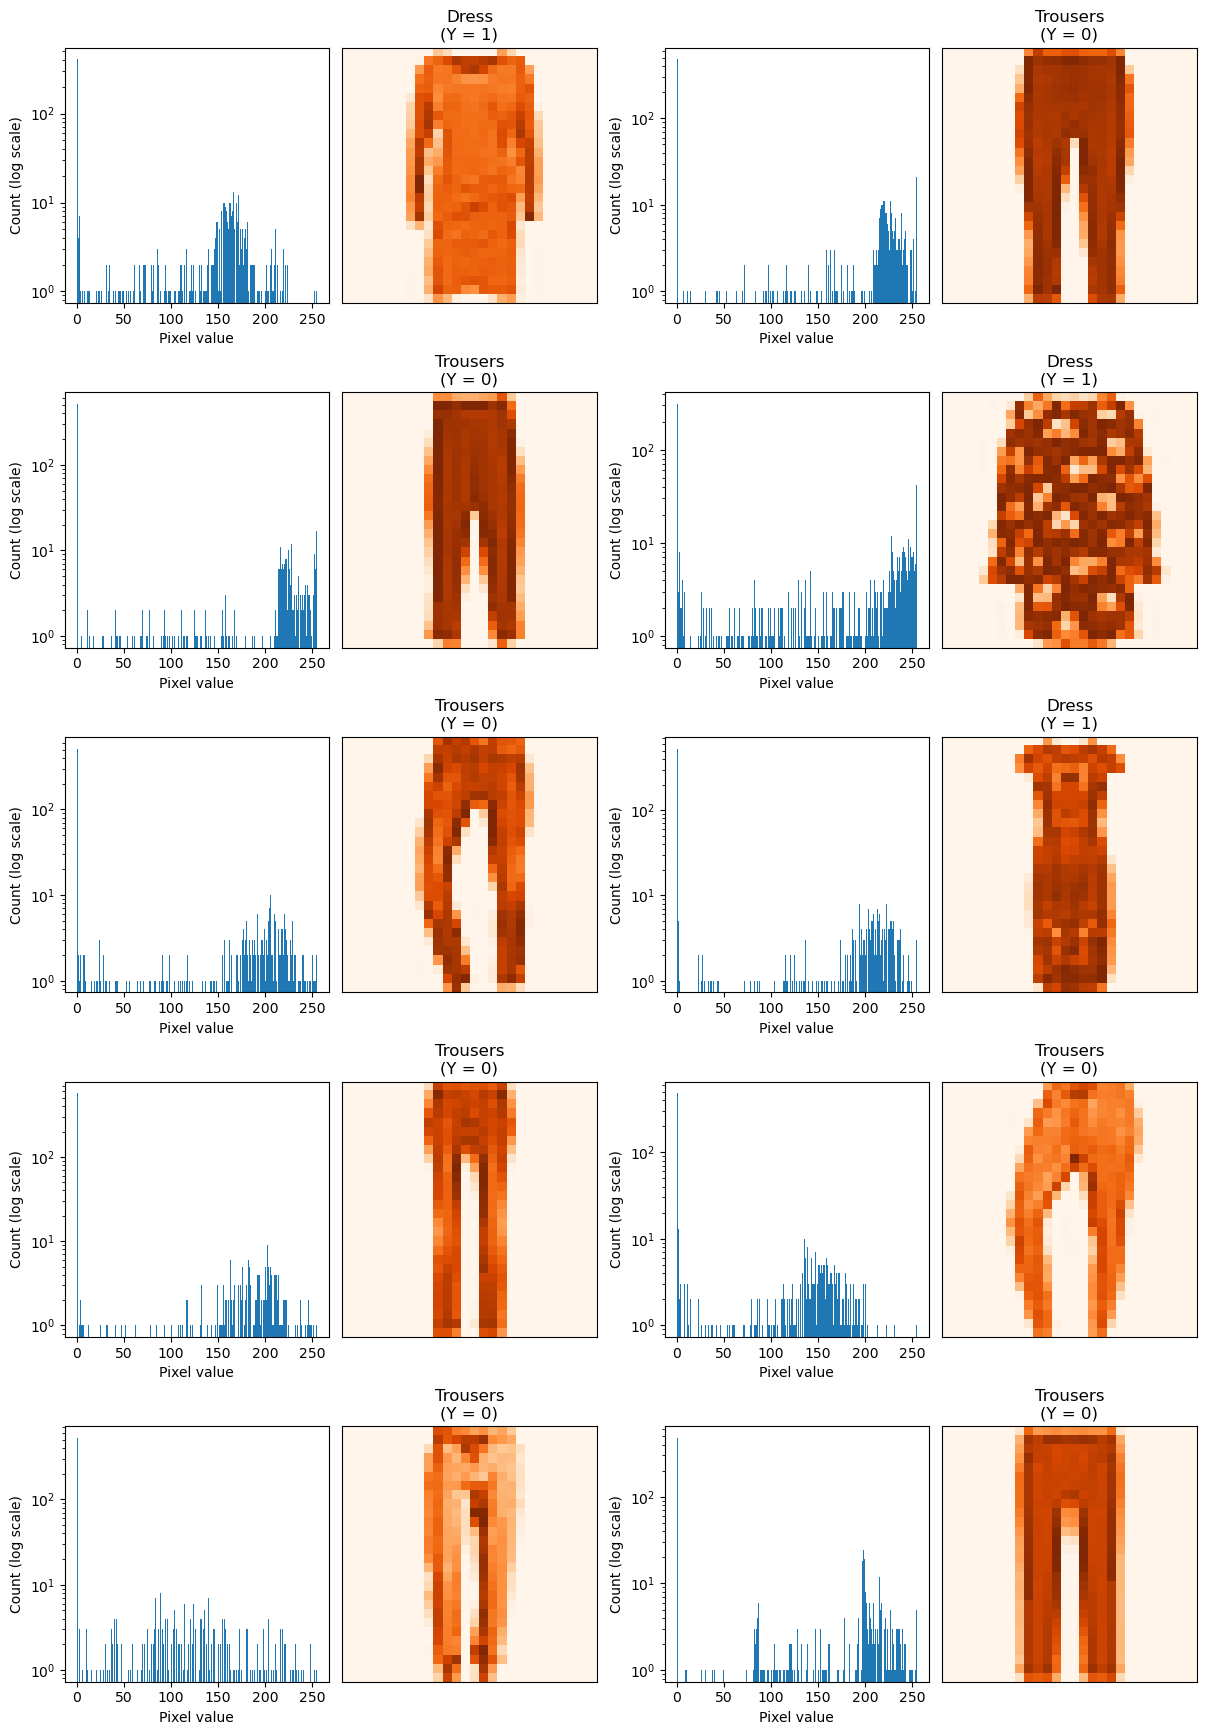

In [22]:
draw_images(images=X_train, y=y_train, scale=3, shape=(5, 2), rd_seed=random_seed)

Podrobneji se podivame na nejaky nahodny obrazek

In [28]:
def inspect_image(image, label=None, index=None, suptitle=None):
    if isinstance(image, pd.DataFrame):
        image = pd.Series(image.iloc[0])
    display(image.describe())
    image_arr = image.to_numpy()
    image = image_arr.reshape((28, 28))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), constrained_layout=True)
    pos = ax1.imshow(image, cmap="Oranges", interpolation="nearest")
    ax1.set_xticks([])
    ax1.set_yticks([])
    if label:
        title = f"{'Trousers' if label == 0 else 'Dress'}"
        if index:
            title += "\n" + f"{index}"
        ax1.set_title(title)
    else:
        ax1.set_title("Image")
    fig.colorbar(mappable=pos)

    ax2.hist(image_arr, bins=256)
    ax2.set_yscale('log')
    ax2.set_title("Image histogram")
    ax2.set_ylabel("Count (log scale)")
    ax2.set_xlabel("Pixel value")

    if suptitle:
        fig.suptitle(suptitle)



Vidime tady dalsi statistiky - stredni hodnotu pixelu, jejich mximalni a minimalni hodnoty.
V bar chartu pozor na logaritmickou skalu) vidime informaci o tom, jak jednotlive pixely jsou distrubovane.

Vidime, ze pixelu s hodnotou 0 mame nejvice, coz je ocekavane, kdyz koukame na obrazek. Muzeme ale uvidet i to jak pixely jsou distribuvoany u samotneho obrazku.

count    784.000000
mean      68.954082
std       80.621709
min        0.000000
25%        0.000000
50%        0.000000
75%      158.250000
max      255.000000
Name: 1669, dtype: float64

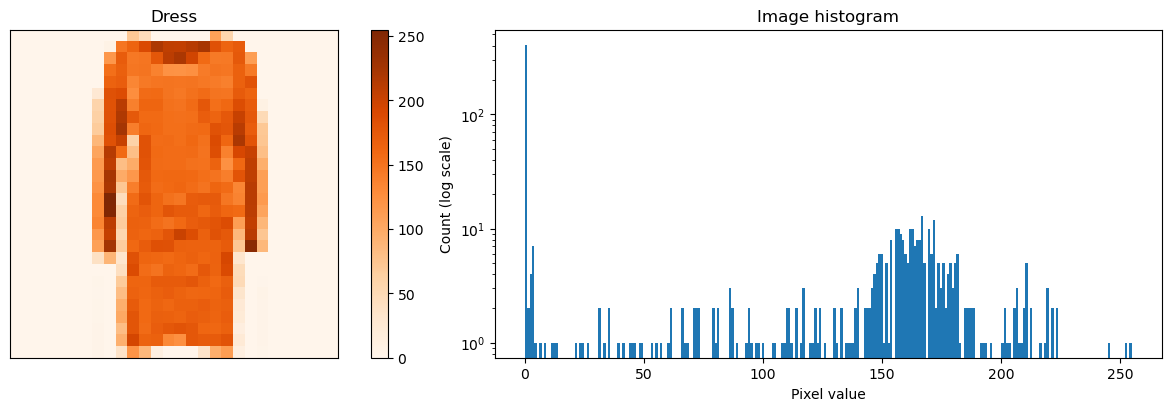

In [29]:
sample_image = X_train.sample(1, random_state=random_seed)
sample_label = y_train[sample_image.index].item()

inspect_image(sample_image, sample_label)

Pro zajimavost, podivame se na to, jak vypada prumerny obrazek pantu a sat, a vsech obrazku dohromady

Vidime, ze ve stredni hodnote mame obrazek, ktery vice pripomina panty, nez saty

count    784.000000
mean      61.181063
std       70.673427
min        0.000000
25%        0.652778
50%       18.737847
75%      135.243924
max      187.043056
dtype: float64

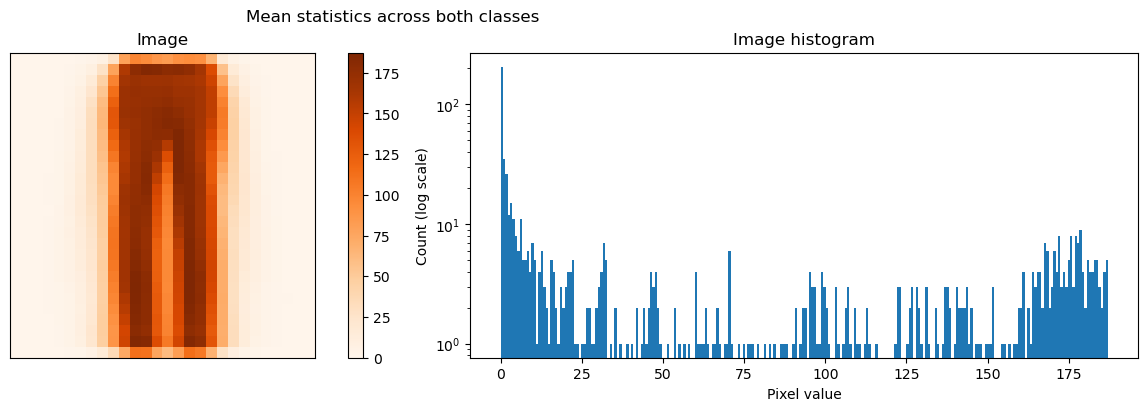

In [31]:
mean_image = pd.Series(X_train.mean(axis=0))
inspect_image(mean_image, suptitle="Mean statistics across both classes")

Pokud se podivame na distribuci trid, vidime, ze jsou dost vyrovnane.

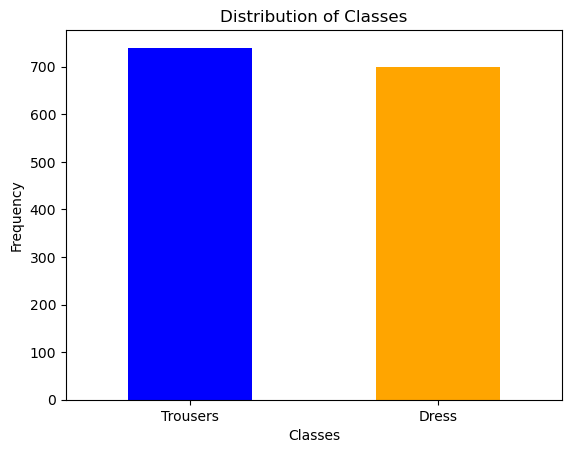

In [12]:
fig, ax = plt.subplots()
class_counts = y_train.value_counts()
g = class_counts.plot(ax=ax, kind='bar', color=['blue', 'orange'])
ax.set_title("Distribution of Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticks(class_counts.index, labels=['Trousers', 'Dress'], rotation=0)
plt.show()

Ted se podivame na stredni obrazek mezi vsemi pantami

count    784.000000
mean      56.563679
std       74.190149
min        0.000000
25%        0.620946
50%        6.450000
75%      120.630405
max      207.806757
dtype: float64

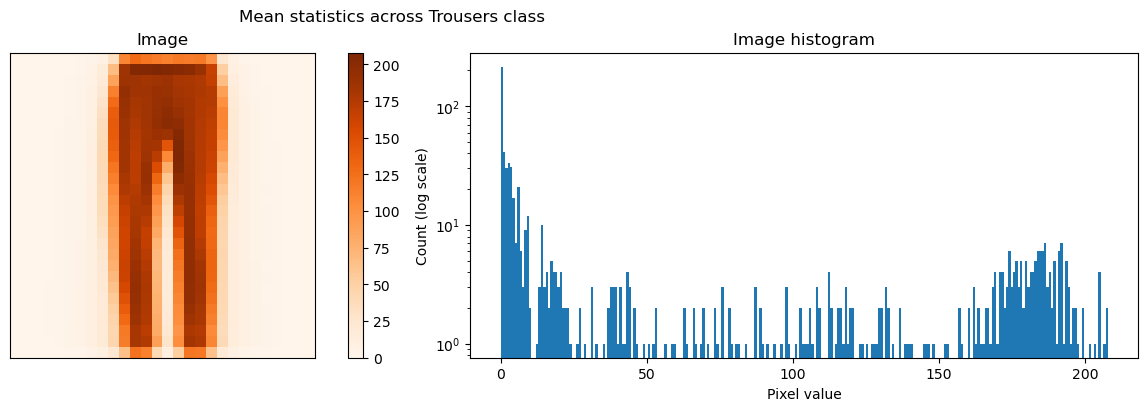

In [13]:
df_trousers = X_train[y_train == 0]
df_trousers_mean = pd.Series(df_trousers.mean(axis=0))
inspect_image(df_trousers_mean, suptitle="Mean statistics across Trousers class")

A na stredni obrazek mezi vsemi satami

count    784.000000
mean      66.062298
std       71.472201
min        0.000000
25%        0.598571
50%       29.988571
75%      150.740357
max      189.927143
dtype: float64

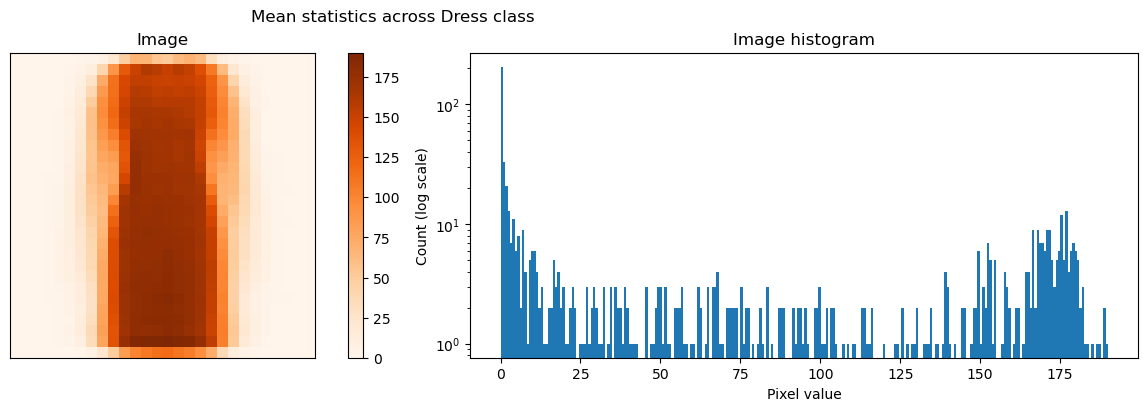

In [32]:
df_dresses = X_train[y_train == 1]
df_dresses_mean = pd.Series(df_dresses.mean(axis=0))
inspect_image(df_dresses_mean, suptitle="Mean statistics across Dress class")

Muzeme si vsimnout, ze usporadanim pixelu na obrazcich umime hned rozpoznat, jestli to jsou saty nebo panty ve stredni hodnote. Ale pokud se podivame na histogram, tak ten rozdil skoro nevidime. Tedy klicovou vlasntnost hraje nejspije rozpolezeni pixelu v prostoru obrazku, nikoliv jejich magnituda. 

# Classification Without Dimensionality Reduction

Nejprve zkusime natrenovat modely na datech bez redukce dimenzionality. Muze nam to dat docela dobrou baselinu pro porovnani kdyz budeme data redukovat. Predem lze rict, ze redukce tady by mela hodne pomoct, protoze nektere dimenze (pixely) jsou nulove napric vsemi obrazky.

## SVM

Prvnim modelem bude Support Vector Machine. 

SVM hyperparameters to fine tune:
- C - regularization hyperparameter 
    - spocitej pro nu 0.1, 0.5, 0.01 - jako reference hodnot pro dataset velky 1440 bodu   
- kernel - linear, poly, rbf, sigmoid TODO vypis funkce
- gamma - spocitej hodnoty scale a auto, a kolem nich vybirej prostor hyperparametru

In [34]:
def train(X, y, model, param_grid, file_name, use_existing=False):
    if use_existing:
        grid_search = pickle.load(file=file_name)
    else:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1,
                                   verbose=5, return_train_score=True)
        grid_search.fit(X=X_cross, y=y_cross)
        pickle.dump(grid_search, file=file_name)

    return grid_search


def evaluate(grid_search, title):
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    mean_test_accuracies = grid_search.cv_results_['mean_train_score']
    mean_val_accuracies = grid_search.cv_results_['mean_test_score']

    fig, ax = plt.subplots(figsize=(20, 7))

    ax.plot(test_accuracies, 'o-', label='train', color='red')
    ax.plot(val_accuracies, 'o-', label='validation', color='navy')
    ax.set_title(title)
    ax.set_xlabel('hyperparameter index')
    ax.set_ylabel('mean accuracy')
    ax.legend(loc="lower right")

In [120]:
C = np.concatenate((np.linspace(start=1e-6, stop=0.01, num=10),
                    np.linspace(start=0.01, stop=1, num=10),
                    np.linspace(start=1, stop=10, num=10),
                    np.linspace(start=10, stop=100, num=10),
                    np.linspace(start=100, stop=1000, num=10)))
C

array([1.000e-06, 1.112e-03, 2.223e-03, 3.334e-03, 4.445e-03, 5.556e-03,
       6.667e-03, 7.778e-03, 8.889e-03, 1.000e-02, 1.000e-02, 1.200e-01,
       2.300e-01, 3.400e-01, 4.500e-01, 5.600e-01, 6.700e-01, 7.800e-01,
       8.900e-01, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
       5.000e+00, 6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01,
       1.000e+01, 2.000e+01, 3.000e+01, 4.000e+01, 5.000e+01, 6.000e+01,
       7.000e+01, 8.000e+01, 9.000e+01, 1.000e+02, 1.000e+02, 2.000e+02,
       3.000e+02, 4.000e+02, 5.000e+02, 6.000e+02, 7.000e+02, 8.000e+02,
       9.000e+02, 1.000e+03])

In [107]:
C_linear = np.concatenate((np.linspace(start=1e-9, stop=0.1e-3, num=100),
                           np.linspace(start=0.01, stop=1, num=10),
                           np.linspace(start=1, stop=10, num=10),
                           np.linspace(start=10, stop=100, num=10),
                           np.linspace(start=100, stop=1000, num=10)
                           ))

In [108]:
X_train.var().mean()

2883.431517828458

In [109]:
X_train.shape

(1440, 784)

In [72]:
gamma_scale = 1 / (X_train.shape[0] * X_train.var().mean())
print(gamma_scale)
gamma_auto = 1 / X_train.shape[0]
print(gamma_auto)
# gamma = np.concatenate((np.linspace(1e-08, 1e-4, num=10)))
gamma = ['scale', 'auto']

2.4083958302829323e-07
0.0006944444444444445


In [128]:
param_grid_linear = {
    'kernel': ['linear'],
    'C': np.linspace(start=1e-9, stop=0.1e-3, num=100)
}

param_grid_poly = {
    'kernel': ['poly'],
    'degree': range(2, 4),
    'gamma': gamma,
    'C': C
}

param_grid_rbf = {
    'kernel': ['sigmoid'],
    'gamma': gamma,
    'C': C
}

param_grid_sigmoid = {
    'kernel': ['sigmoid'],
    'gamma': gamma,
    'C': C
}

param_grid = [param_grid_linear, param_grid_poly, param_grid_rest]


In [111]:
## SVM
model = SVC()

In [112]:
X_cross = pd.concat((X_train, X_val))
y_cross = pd.concat((y_train, y_val))

### Linear

In [113]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_linear, scoring='accuracy', cv=5, n_jobs=-1,
                           verbose=5, return_train_score=True)
grid_search.fit(X=X_cross, y=y_cross)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 5/5] END C=1.0110909090909092e-06, kernel=linear;, score=(train=0.986, test=0.973) total time=   0.9s
[CV 3/5] END C=3.031272727272727e-06, kernel=linear;, score=(train=0.991, test=0.978) total time=   0.9s
[CV 5/5] END C=4.041363636363636e-06, kernel=linear;, score=(train=0.994, test=0.968) total time=   0.8s
[CV 5/5] END C=5.051454545454545e-06, kernel=linear;, score=(train=0.994, test=0.970) total time=   0.7s
[CV 2/5] END C=7.071636363636363e-06, kernel=linear;, score=(train=0.996, test=0.973) total time=   0.7s
[CV 3/5] END C=8.081727272727273e-06, kernel=linear;, score=(train=0.998, test=0.978) total time=   0.8s
[CV 5/5] END C=9.091818181818183e-06, kernel=linear;, score=(train=0.999, test=0.965) total time=   0.8s
[CV 2/5] END C=1.1112000000000001e-05, kernel=linear;, score=(train=0.999, test=0.960) total time=   0.8s
[CV 3/5] END C=1.2122090909090909e-05, kernel=linear;, score=(train=1.000, test=0.973) total ti

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-09, 1.01109091e-06, 2.02118182e-06, 3.03127273e-06,
       4.04136364e-06, 5.05145455e-06, 6.06154545e-06, 7.07163636e-06,
       8.08172727e-06, 9.09181818e-06, 1.01019091e-05, 1.11120000e-05,
       1.21220909e-05, 1.31321818e-05, 1.41422727e-05, 1.51523636e-05,
       1.61624545e-05, 1.71725455e-05, 1.81826364e-0...
       8.08082727e-05, 8.18183636e-05, 8.28284545e-05, 8.38385455e-05,
       8.48486364e-05, 8.58587273e-05, 8.68688182e-05, 8.78789091e-05,
       8.88890000e-05, 8.98990909e-05, 9.09091818e-05, 9.19192727e-05,
       9.29293636e-05, 9.39394545e-05, 9.49495455e-05, 9.59596364e-05,
       9.69697273e-05, 9.79798182e-05, 9.89899091e-05, 1.00000000e-04]),
                         'kernel': ['linear']},
             return_train_score=True, scoring='accuracy', verbose=5)

In [119]:
grid_search.best_params_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 6.061545454545454e-06, 'kernel': 'linear'}
Best score: 0.9776785494926663


In [115]:
test_accuracies = grid_search.cv_results_['mean_train_score']
val_accuracies = grid_search.cv_results_['mean_test_score']

In [116]:
best_model = SVC(C=1e-06, kernel='linear')
best_model.fit(X_train, y_train)
metrics.accuracy_score(y_val, best_model.predict(X_val))

0.96875

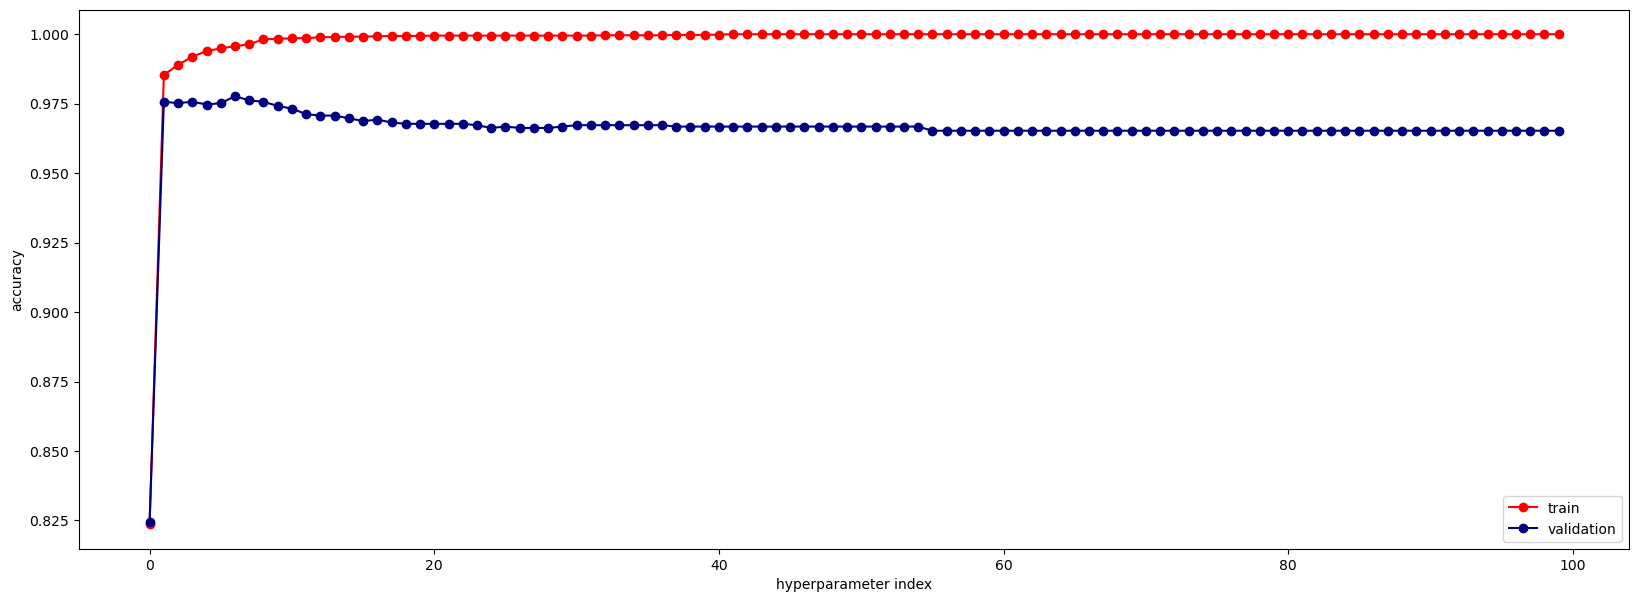

In [118]:
grid_search.param_grid

{'kernel': ['linear'],
 'C': array([1.00000000e-09, 1.01109091e-06, 2.02118182e-06, 3.03127273e-06,
        4.04136364e-06, 5.05145455e-06, 6.06154545e-06, 7.07163636e-06,
        8.08172727e-06, 9.09181818e-06, 1.01019091e-05, 1.11120000e-05,
        1.21220909e-05, 1.31321818e-05, 1.41422727e-05, 1.51523636e-05,
        1.61624545e-05, 1.71725455e-05, 1.81826364e-05, 1.91927273e-05,
        2.02028182e-05, 2.12129091e-05, 2.22230000e-05, 2.32330909e-05,
        2.42431818e-05, 2.52532727e-05, 2.62633636e-05, 2.72734545e-05,
        2.82835455e-05, 2.92936364e-05, 3.03037273e-05, 3.13138182e-05,
        3.23239091e-05, 3.33340000e-05, 3.43440909e-05, 3.53541818e-05,
        3.63642727e-05, 3.73743636e-05, 3.83844545e-05, 3.93945455e-05,
        4.04046364e-05, 4.14147273e-05, 4.24248182e-05, 4.34349091e-05,
        4.44450000e-05, 4.54550909e-05, 4.64651818e-05, 4.74752727e-05,
        4.84853636e-05, 4.94954545e-05, 5.05055455e-05, 5.15156364e-05,
        5.25257273e-05, 5.35358182e-

### Poly

In [123]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_poly, scoring='accuracy', cv=5, n_jobs=-1,
                           verbose=5, return_train_score=True)
grid_search.fit(X=X_cross, y=y_cross)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END C=1e-06, degree=2, gamma=scale, kernel=poly;, score=(train=0.514, test=0.515) total time=   7.1s
[CV 5/5] END C=0.001112, degree=2, gamma=auto, kernel=poly;, score=(train=1.000, test=0.973) total time=   0.8s
[CV 1/5] END C=0.001112, degree=3, gamma=auto, kernel=poly;, score=(train=1.000, test=0.978) total time=   0.7s
[CV 4/5] END C=0.001112, degree=3, gamma=auto, kernel=poly;, score=(train=1.000, test=0.968) total time=   0.8s
[CV 1/5] END C=0.002223, degree=2, gamma=scale, kernel=poly;, score=(train=0.731, test=0.762) total time=   6.9s
[CV 5/5] END C=0.002223, degree=3, gamma=auto, kernel=poly;, score=(train=1.000, test=0.970) total time=   0.8s
[CV 4/5] END C=0.003334, degree=2, gamma=scale, kernel=poly;, score=(train=0.823, test=0.821) total time=   6.7s
[CV 2/5] END C=0.004445, degree=2, gamma=auto, kernel=poly;, score=(train=1.000, test=0.975) total time=   0.8s
[CV 4/5] END C=0.004445, degree=2, gamma

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.000e-06, 1.112e-03, 2.223e-03, 3.334e-03, 4.445e-03, 5.556e-03,
       6.667e-03, 7.778e-03, 8.889e-03, 1.000e-02, 1.000e-02, 1.200e-01,
       2.300e-01, 3.400e-01, 4.500e-01, 5.600e-01, 6.700e-01, 7.800e-01,
       8.900e-01, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
       5.000e+00, 6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01,
       1.000e+01, 2.000e+01, 3.000e+01, 4.000e+01, 5.000e+01, 6.000e+01,
       7.000e+01, 8.000e+01, 9.000e+01, 1.000e+02, 1.000e+02, 2.000e+02,
       3.000e+02, 4.000e+02, 5.000e+02, 6.000e+02, 7.000e+02, 8.000e+02,
       9.000e+02, 1.000e+03]),
                         'degree': range(2, 4), 'gamma': ['scale', 'auto'],
                         'kernel': ['poly']},
             return_train_score=True, scoring='accuracy', verbose=5)

In [124]:
test_accuracies = grid_search.cv_results_['mean_train_score']
val_accuracies = grid_search.cv_results_['mean_test_score']

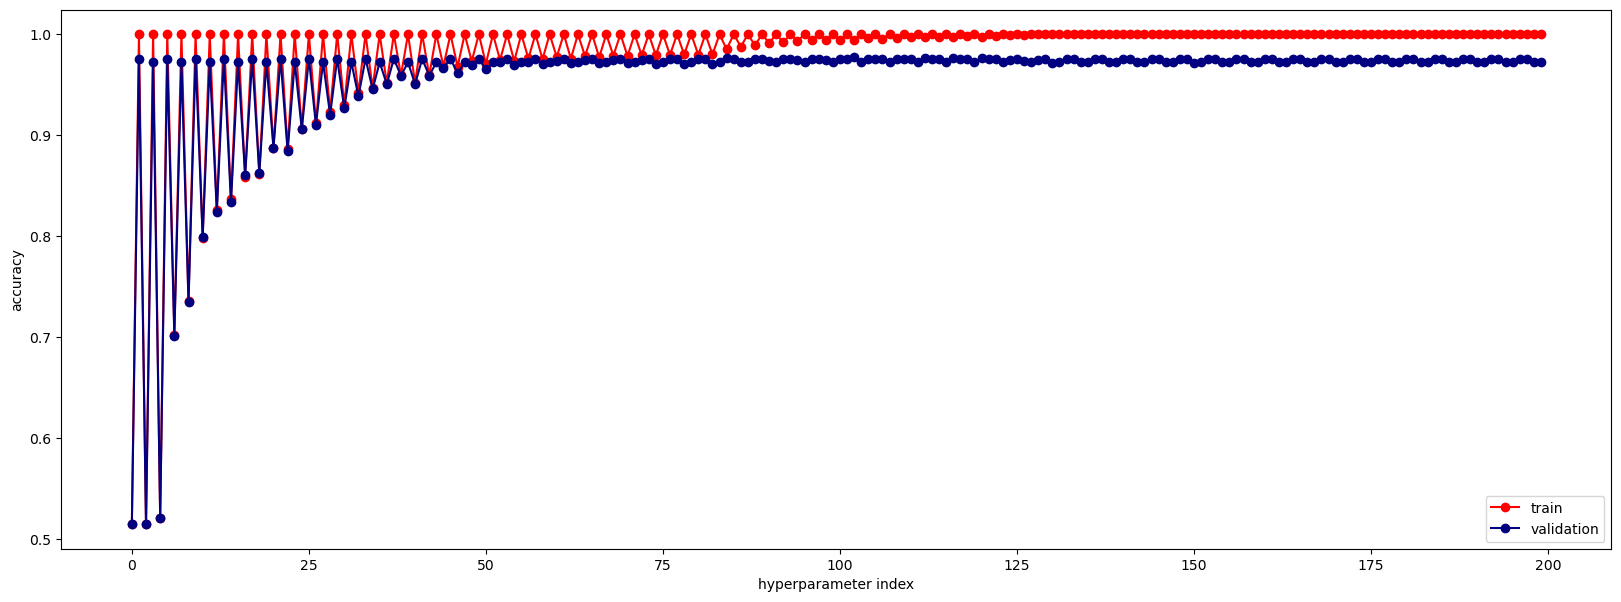

In [125]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(test_accuracies, 'o-', label='train', color='red')
ax.plot(val_accuracies, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")


In [126]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 6.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best score: 0.9771798147556691


### RBF

In [129]:
grid_search_rbf = GridSearchCV(estimator=model, param_grid=param_grid_rbf, scoring='accuracy', cv=5, n_jobs=-1,
                               verbose=5, return_train_score=True)
grid_search_rbf.fit(X=X_cross, y=y_cross)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.000e-06, 1.112e-03, 2.223e-03, 3.334e-03, 4.445e-03, 5.556e-03,
       6.667e-03, 7.778e-03, 8.889e-03, 1.000e-02, 1.000e-02, 1.200e-01,
       2.300e-01, 3.400e-01, 4.500e-01, 5.600e-01, 6.700e-01, 7.800e-01,
       8.900e-01, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
       5.000e+00, 6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01,
       1.000e+01, 2.000e+01, 3.000e+01, 4.000e+01, 5.000e+01, 6.000e+01,
       7.000e+01, 8.000e+01, 9.000e+01, 1.000e+02, 1.000e+02, 2.000e+02,
       3.000e+02, 4.000e+02, 5.000e+02, 6.000e+02, 7.000e+02, 8.000e+02,
       9.000e+02, 1.000e+03]),
                         'gamma': ['scale', 'auto'], 'kernel': ['sigmoid']},
             return_train_score=True, scoring='accuracy', verbose=5)

In [132]:
test_accuracies = grid_search_rbf.cv_results_['mean_train_score']
val_accuracies = grid_search_rbf.cv_results_['mean_test_score']

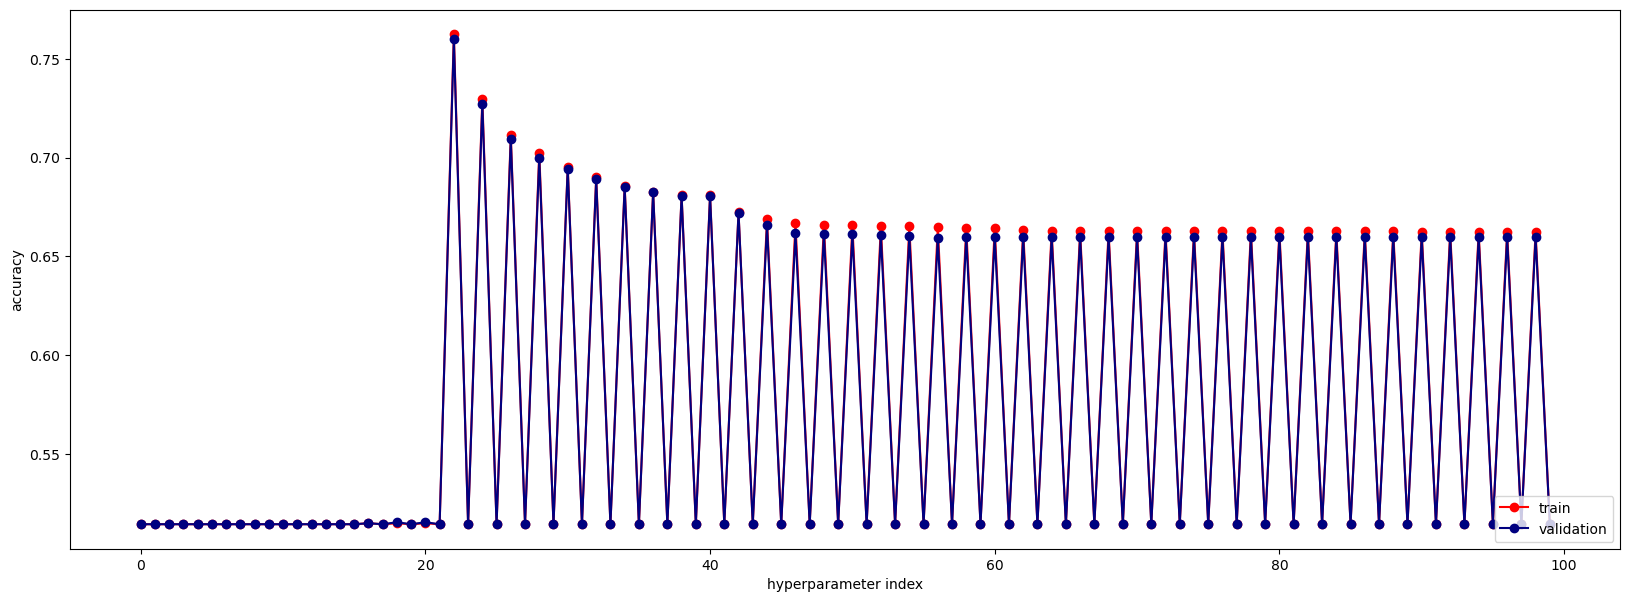

In [133]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(test_accuracies, 'o-', label='train', color='red')
ax.plot(val_accuracies, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")

In [134]:
print("Best parameters:", grid_search_rbf.best_params_)
print("Best score:", grid_search_rbf.best_score_)

Best parameters: {'C': 0.12, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score: 0.759920644669926


### Sigmoid

In [136]:
param_grid_sigmoid = {
    'kernel': ['sigmoid'],
    'gamma': gamma,
    'C': C
}

In [138]:
grid_search_sigmoid = GridSearchCV(estimator=model, param_grid=param_grid_sigmoid, scoring='accuracy', cv=5, n_jobs=-1,
                                   verbose=6, return_train_score=True)
grid_search_sigmoid.fit(X=X_cross, y=y_cross)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.000e-06, 1.112e-03, 2.223e-03, 3.334e-03, 4.445e-03, 5.556e-03,
       6.667e-03, 7.778e-03, 8.889e-03, 1.000e-02, 1.000e-02, 1.200e-01,
       2.300e-01, 3.400e-01, 4.500e-01, 5.600e-01, 6.700e-01, 7.800e-01,
       8.900e-01, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
       5.000e+00, 6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01,
       1.000e+01, 2.000e+01, 3.000e+01, 4.000e+01, 5.000e+01, 6.000e+01,
       7.000e+01, 8.000e+01, 9.000e+01, 1.000e+02, 1.000e+02, 2.000e+02,
       3.000e+02, 4.000e+02, 5.000e+02, 6.000e+02, 7.000e+02, 8.000e+02,
       9.000e+02, 1.000e+03]),
                         'gamma': ['scale', 'auto'], 'kernel': ['sigmoid']},
             return_train_score=True, scoring='accuracy', verbose=6)

In [139]:
test_accuracies = grid_search_sigmoid.cv_results_['mean_train_score']
val_accuracies = grid_search_sigmoid.cv_results_['mean_test_score']

Best parameters: {'C': 0.12, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score: 0.759920644669926


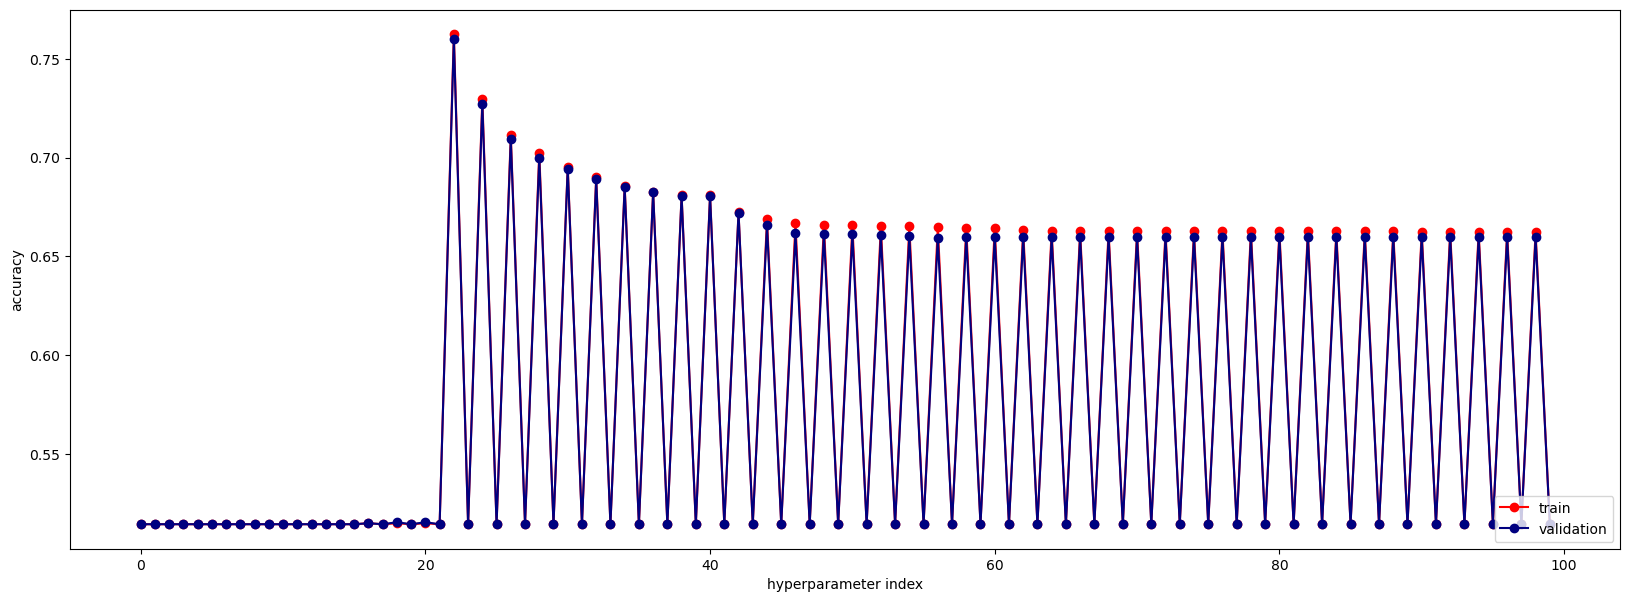

In [140]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(test_accuracies, 'o-', label='train', color='red')
ax.plot(val_accuracies, 'o-', label='validation', color='navy')
ax.set_xlabel('hyperparameter index')
ax.set_ylabel('accuracy')
ax.legend(loc="lower right")
print("Best parameters:", grid_search_sigmoid.best_params_)
print("Best score:", grid_search_sigmoid.best_score_)

## NB

## LDA

# PCA

# LLE